### Notebook to process benchmar results

Please run this notebook after running all the benchmarks and storing them in the `results` dir. This will export them in the desired format for the single node benchmark plots of [qdrant.tech/benchmarks](https://qdrant.tech/benchmarks)

In [139]:
from pathlib import Path
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timezone

In [140]:
DATA_DIR = Path().resolve().parent / "results"
DATA_DIR, list(DATA_DIR.glob("*.json"))[0].name

(WindowsPath('C:/git/vector-db-benchmark/results'),
 'elasticsearch-m-16-ef-128-europeana-all-search-0-2024-09-27-15-32-36.json')

In [141]:
PATH_REGEX = re.compile(r"(?P<engine_name>("
                        r"?P<engine>[a-zA-Z0-9\-]+)"
                        r"\-m\-(?P<m>[a-zA-Z0-9]+)"
                        r"\-ef\-(?P<ef>[a-zA-Z0-9]+)"
                        r")"
                        r"\-(?P<dataset>[a-zA-Z0-9\-]+)"
                        r"\-(?P<operation>(search)|(upload))"
                        r"(\-(?P<search_index>[0-9]{1,2})\-)?"
                        r"\-?(?P<date>.*)\.json")

In [142]:
upload_results, search_results = [], []

for path in DATA_DIR.glob("*.json"):
    match = PATH_REGEX.match(path.name)
    if match is None:
        continue

    experiment = match.groupdict()

    with open(path, "r") as fp:
        stats = json.load(fp)

    params = stats["params"]
    dataset = params.pop("dataset")
    engine = params.pop("engine")

    entry = {
        "dataset": dataset,
        "engine": engine,
        "m": match["m"],
        "ef": match["ef"],
        "date": match["date"],
        "params": params,
        "results": stats["results"],
    }

    if experiment["operation"] == "search":
        entry.update({"search_index": match["search_index"]})
        search_results.append(entry)
    elif experiment["operation"] == "upload":
        upload_results.append(entry)
    else:
        raise Exception("Unknown operation")

len(upload_results), len(search_results)

(6, 40)

In [143]:
upload_results, search_results[0]

([{'dataset': 'europeana-all',
   'engine': 'elasticsearch',
   'm': '16',
   'ef': '128',
   'date': '2024-09-27-15-32-21',
   'params': {'experiment': 'elasticsearch-m-16-ef-128',
    'parallel': 16,
    'index_options': {'m': 16, 'ef_construction': 128}},
   'results': {'post_upload': {},
    'upload_time': 11927.576406253036,
    'total_time': 96497.39399532299}},
  {'dataset': 'europeana-all',
   'engine': 'milvus',
   'm': '16',
   'ef': '128',
   'date': '2024-09-18-02-03-37',
   'params': {'experiment': 'milvus-m-16-ef-128',
    'parallel': 16,
    'index_params': {'efConstruction': 128, 'M': 16}},
   'results': {'post_upload': {},
    'upload_time': 3037.5825580669334,
    'total_time': 5517.605082381982}},
  {'dataset': 'europeana-all',
   'engine': 'milvus',
   'm': '16',
   'ef': '128',
   'date': '2024-09-18-14-20-32',
   'params': {'experiment': 'milvus-m-16-ef-128',
    'parallel': 16,
    'index_params': {'efConstruction': 128, 'M': 16}},
   'results': {'post_upload': {

In [144]:
#settings for showing the whole column values (not truncated)
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

upload_df = pd.DataFrame(upload_results)
upload_df["date"] = pd.to_datetime(upload_df["date"], format="%Y-%m-%d-%H-%M-%S")
upload_df = upload_df.sort_values("date", ascending=False) \
    .groupby(["engine", "m", "ef", "dataset"]) \
    .first()

temp_df = upload_df.copy()
temp_df["total_time"] = temp_df["results"].apply(lambda x: x["total_time"])
temp_df.sort_values("total_time", ascending=True).head(10)

,,,,date,params,results,total_time
engine,m,ef,dataset,,,,
milvus,16,128,europeana-all,2024-09-18 14:20:32,"{'experiment': 'milvus-m-16-ef-128', 'parallel': 16, 'index_params': {'efConstruction': 128, 'M': 16}}","{'post_upload': {}, 'upload_time': 3182.6313478669617, 'total_time': 5670.570973078953}",5670.570973
qdrantcluster,16,128,europeana-all,2024-10-09 21:55:24,"{'experiment': 'qdrantcluster-m-16-ef-128', 'parallel': 16, 'optimizers_config': {'memmap_threshold': 10000000}, 'hnsw_config': {'m': 16, 'ef_construct': 128}}","{'post_upload': {}, 'upload_time': 4572.617778775748, 'total_time': 10797.474939736072}",10797.474940
qdrant,16,128,europeana-all,2024-09-20 02:29:14,"{'experiment': 'qdrant-m-16-ef-128', 'parallel': 16, 'optimizers_config': {'memmap_threshold': 10000000}, 'hnsw_config': {'m': 16, 'ef_construct': 128}}","{'post_upload': {}, 'upload_time': 2718.5883527550614, 'total_time': 11420.899320694036}",11420.899321
milvusIVFSQ8,null,null,europeana-all,2024-10-01 07:10:47,"{'experiment': 'milvusIVFSQ8-m-null-ef-null', 'parallel': 16, 'index_params': {'nlist': 16384}}","{'post_upload': {}, 'upload_time': 3041.7816643069964, 'total_time': 23070.902847833}",23070.902848
elasticsearch,16,128,europeana-all,2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options': {'m': 16, 'ef_construction': 128}}","{'post_upload': {}, 'upload_time': 11927.576406253036, 'total_time': 96497.39399532299}",96497.393995


In [145]:
search_df = pd.DataFrame(search_results)
#search_df=search_df[search_df["engine"]=='qdrantcluster']
search_df["date"] = pd.to_datetime(search_df["date"], format="%Y-%m-%d-%H-%M-%S")
search_df = search_df.sort_values("date", ascending=False) \
    .groupby(["engine", "m", "ef", "dataset", "search_index"]) \
    .first()

temp_df = search_df.copy()
temp_df['rps'] = temp_df['results'].apply(lambda x: x["rps"])
temp_df.sort_values("rps", ascending=False).head(n=10)

,,,,,date,params,results,rps
engine,m,ef,dataset,search_index,,,,
qdrant,16,128,europeana-all,4,2024-09-20 02:29:34,"{'experiment': 'qdrant-m-16-ef-128', 'parallel': 100, 'config': {'hnsw_ef': 64}}","{'total_time': 0.49271493300329894, 'mean_time': 0.23008065274218098, 'mean_precisions': 0.95, 'std_time': 0.09755879067648322, 'min_time': 0.05707773403264582, 'max_time': 0.39675474097020924, 'rps': 202.9571123214373, 'p95_time': 0.3711829639330972, 'p99_time': 0.3863179313286674}",202.957112
qdrantcluster,16,128,europeana-all,4,2024-10-09 21:55:45,"{'experiment': 'qdrantcluster-m-16-ef-128', 'parallel': 100, 'config': {'hnsw_ef': 64}}","{'total_time': 0.5567572480067611, 'mean_time': 0.345145850898698, 'mean_precisions': 0.69, 'std_time': 0.06775349283897839, 'min_time': 0.12727736681699753, 'max_time': 0.49038215726614, 'rps': 179.61149200663056, 'p95_time': 0.45491966512054205, 'p99_time': 0.46810648700222385}",179.611492
qdrant,16,128,europeana-all,0,2024-09-20 02:29:15,"{'experiment': 'qdrant-m-16-ef-128', 'parallel': 1, 'config': {'hnsw_ef': 64}}","{'total_time': 0.6115625849924982, 'mean_time': 0.0060357550322078166, 'mean_precisions': 0.95, 'std_time': 0.004380227925120563, 'min_time': 0.004370110924355686, 'max_time': 0.04163971194066107, 'rps': 163.51556235446722, 'p95_time': 0.008655158552573993, 'p99_time': 0.02489279086817996}",163.515562
qdrantcluster,16,128,europeana-all,0,2024-10-09 21:55:25,"{'experiment': 'qdrantcluster-m-16-ef-128', 'parallel': 1, 'config': {'hnsw_ef': 64}}","{'total_time': 0.6244188309647143, 'mean_time': 0.00615905505605042, 'mean_precisions': 0.69, 'std_time': 0.003954479947955708, 'min_time': 0.0044394549913704395, 'max_time': 0.035420577973127365, 'rps': 160.14891774724674, 'p95_time': 0.010414235969074068, 'p99_time': 0.02736790413968269}",160.148918
qdrant,16,128,europeana-all,5,2024-09-20 02:29:50,"{'experiment': 'qdrant-m-16-ef-128', 'parallel': 100, 'config': {'hnsw_ef': 128}}","{'total_time': 0.6792151329573244, 'mean_time': 0.2792211350146681, 'mean_precisions': 0.97, 'std_time': 0.12963233521947046, 'min_time': 0.018855438916943967, 'max_time': 0.49097677203826606, 'rps': 147.22875735202896, 'p95_time': 0.4670799677784089, 'p99_time': 0.48947467970079744}",147.228757
qdrantcluster,16,128,europeana-all,5,2024-10-09 21:56:01,"{'experiment': 'qdrantcluster-m-16-ef-128', 'parallel': 100, 'config': {'hnsw_ef': 128}}","{'total_time': 0.7240351806394756, 'mean_time': 0.333101415336132, 'mean_precisions': 0.83, 'std_time': 0.11655170929262891, 'min_time': 0.07563631003722548, 'max_time': 0.521897398866713, 'rps': 138.11483567922616, 'p95_time': 0.4879034450743347, 'p99_time': 0.5216301881102845}",138.114836
qdrant,16,128,europeana-all,1,2024-09-20 02:29:15,"{'experiment': 'qdrant-m-16-ef-128', 'parallel': 1, 'config': {'hnsw_ef': 128}}","{'total_time': 0.7583689070306718, 'mean_time': 0.007498764547053724, 'mean_precisions': 0.97, 'std_time': 0.0010459449492817236, 'min_time': 0.006272553000599146, 'max_time': 0.012520562973804772, 'rps': 131.86194617543248, 'p95_time': 0.009165276662679389, 'p99_time': 0.012474046795396135}",131.861946
qdrantcluster,16,128,europeana-all,1,2024-10-09 21:55:26,"{'experiment': 'qdrantcluster-m-16-ef-128', 'parallel': 1, 'config': {'hnsw_ef': 128}}","{'total_time': 0.9355029999278486, 'mean_time': 0.009257888030260801, 'mean_precisions': 0.83, 'std_time': 0.0018160018606486756, 'min_time': 0.00688333110883832, 'max_time': 0.017278135754168034, 'rps': 106.89436592689984, 'p95_time': 0.012449091998860238, 'p99_time': 0.01715793016832322}",106.894366
elasticsearch,16,128,europeana-all,3,2024-09-27 15:33:03,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 100, 'config': {'num_candidates': 128}}","{'total_time': 0.9632914359681308, 'mean_time': 0.015998547945637254, 'mean_precisions': 0.17, 'std_time': 0.010291294797444228, 'min_time': 0.00606965203769505, 'max_time': 0.06418960192240775, 'rps': 103.8107433182956, 'p95_time': 0.036034184065647415, 'p99_ti

In [146]:
_search = search_df.reset_index()
_upload = upload_df.reset_index()

joined_df = _search.merge(_upload, on=["engine", "m", "ef", "dataset"], how="left", suffixes=("_search", "_upload"))
print(len(joined_df))
joined_df

34


,engine,m,ef,dataset,search_index,date_search,params_search,results_search,date_upload,params_upload,results_upload
0,elasticsearch,16,128,europeana-all,0,2024-09-27 15:32:36,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 1, 'config': {'num_candidates': 128}}","{'total_time': 15.826053492026404, 'mean_time': 0.1577054476016201, 'mean_precisions': 0.17, 'std_time': 0.16629924885852443, 'min_time': 0.006731483852490783, 'max_time': 0.7053609360009432, 'rps': 6.318694679654831, 'p95_time': 0.47166681464295823, 'p99_time': 0.6950206433353014}",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options': {'m': 16, 'ef_construction': 128}}","{'post_upload': {}, 'upload_time': 11927.576406253036, 'total_time': 96497.39399532299}"
1,elasticsearch,16,128,europeana-all,1,2024-09-27 15:32:41,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 1, 'config': {'num_candidates': 256}}","{'total_time': 4.567325653042644, 'mean_time': 0.04549739266512916, 'mean_precisions': 0.22, 'std_time': 0.054441951575504105, 'min_time': 0.0046893039252609015, 'max_time': 0.23438507784157991, 'rps': 21.894650742362188, 'p95_time': 0.17492653747322034, 'p99_time': 0.21189654374029498}",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options': {'m': 16, 'ef_construction': 128}}","{'post_upload': {}, 'upload_time': 11927.576406253036, 'total_time': 96497.39399532299}"
2,elasticsearch,16,128,europeana-all,2,2024-09-27 15:32:47,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 1, 'config': {'num_candidates': 512}}","{'total_time': 5.704668842954561, 'mean_time': 0.05681015790905804, 'mean_precisions': 0.26, 'std_time': 0.056313726069129835, 'min_time': 0.008684577886015177, 'max_time': 0.25408858992159367, 'rps': 17.529501317767643, 'p95_time': 0.18337479167385023, 'p99_time': 0.23577874786686162}",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options': {'m': 16, 'ef_construction': 128}}","{'post_upload': {}, 'upload_time': 11927.576406253036, 'total_time': 96497.39399532299}"
3,elasticsearch,16,128,europeana-all,3,2024-09-27 15:33:03,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 100, 'config': {'num_candidates': 128}}","{'total_time': 0.9632914359681308, 'mean_time': 0.015998547945637254, 'mean_precisions': 0.17, 'std_time': 0.010291294797444228, 'min_time': 0.00606965203769505, 'max_time': 0.06418960192240775, 'rps': 103.8107433182956, 'p95_time': 0.036034184065647415, 'p99_time': 0.04628897043643528}",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options': {'m': 16, 'ef_construction': 128}}","{'post_upload': {}, 'upload_time': 11927.576406253036, 'total_time': 96497.39399532299}"
4,elasticsearch,16,128,europeana-all,4,2024-09-27 15:33:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 100, 'config': {'num_candidates': 256}}","{'total_time': 2.1976373449433595, 'mean_time': 0.02513823352055624, 'mean_precisions': 0.22, 'std_time': 0.034185232498341774, 'min_time': 0.007124599069356918, 'max_time': 0.2614269389305264, 'rps': 45.50341312232175, 'p95_time': 0.03590372469043359, 'p99_time': 0.2559543316951022}",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options': {'m': 16, 'ef_construction': 128}}","{'post_upload': {}, 'upload_time': 11927.576406253036, 'total_time': 96497.39399532299}"
5,elasticsearch,16,128,europeana-all,5,2024-09-27 15:33:38,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 100, 'config': {'num_candidates': 512}}","{'total_time': 2.0765163509640843, 'mean_time': 0.01895588289014995, 'mean_precisions': 0.26, 'std_time': 0.007103341185069494, 'min_time': 0.008401088882237673, 'max_time': 0.046966901049017906, 'rps': 48.15757889581367, 'p95_time': 0.03536593217868357, 'p99_time': 0.04517471979139374}",2024-09-27 15:32:21,"{'experiment': 'elasticsearch-m-16-ef-128', 'parallel': 16, 'index_options':

{'engine_name': 'qdrantcluster', 'setup_name': 'qdrantcluster-m-16-ef-128', 'dataset_name': 'europeana-all', 'search_idx': '7', 'upload_time': 4572.617778775748, 'total_upload_time': 10797.474939736072, 'p95_time': 1.4439787654671818, 'rps': 52.8891312322225, 'parallel': 100, 'p99_time': 1.526832978995517, 'mean_time': 0.846166514554061, 'mean_precisions': 0.92, 'engine_params': {'optimizers_config': {'memmap_threshold': 10000000}, 'hnsw_config': {'m': 16, 'ef_construct': 128}, 'hnsw_ef': 512}} 34


<BarContainer object of 5 artists>

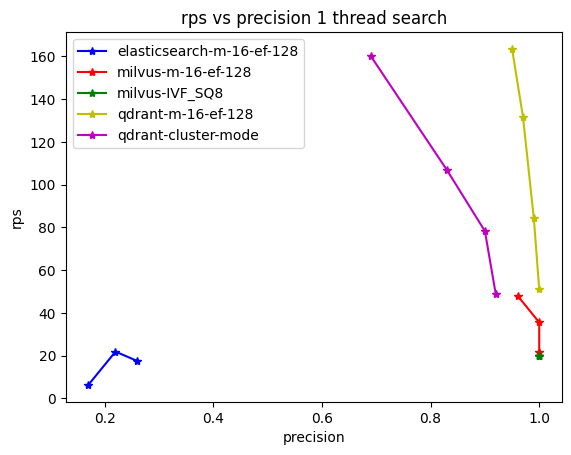

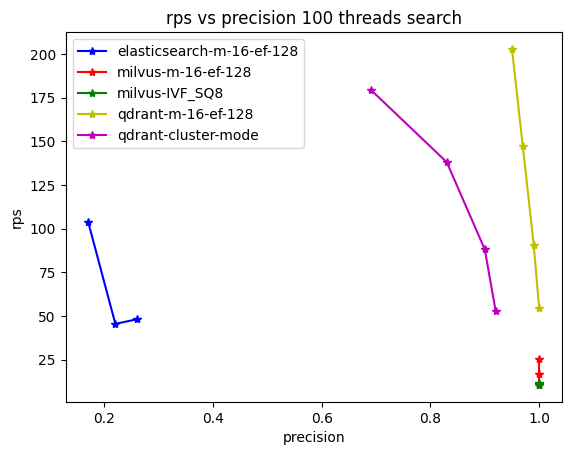

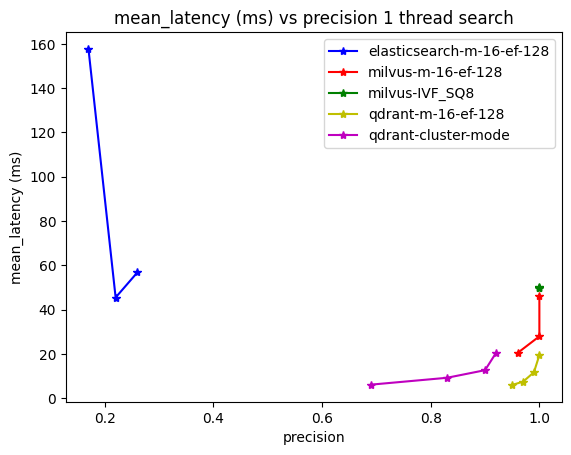

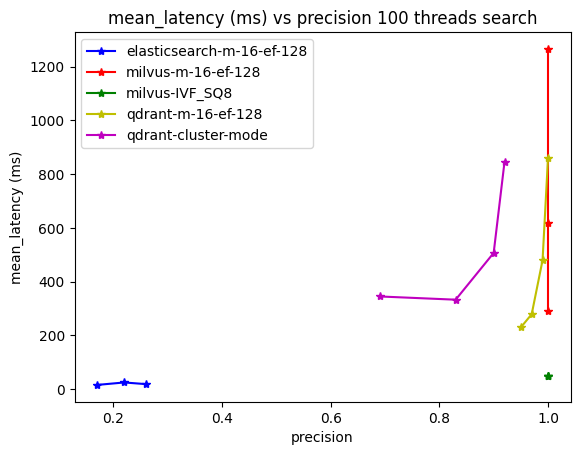

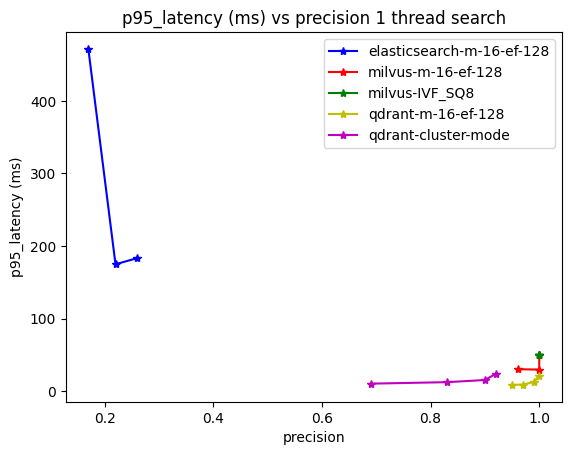

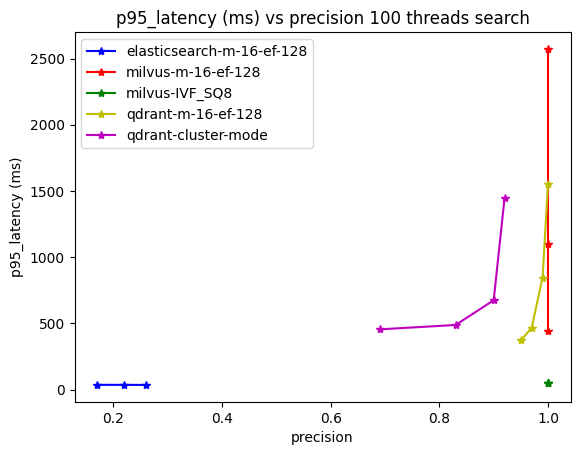

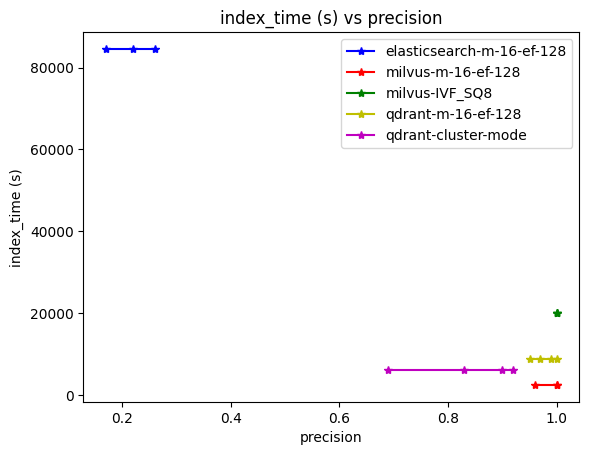

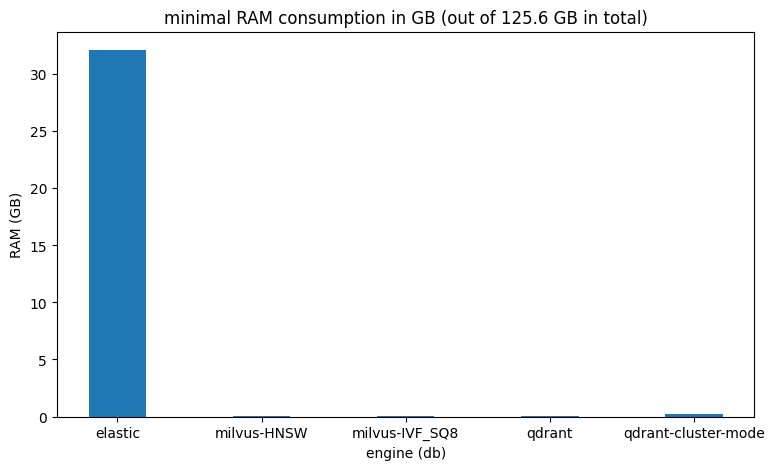

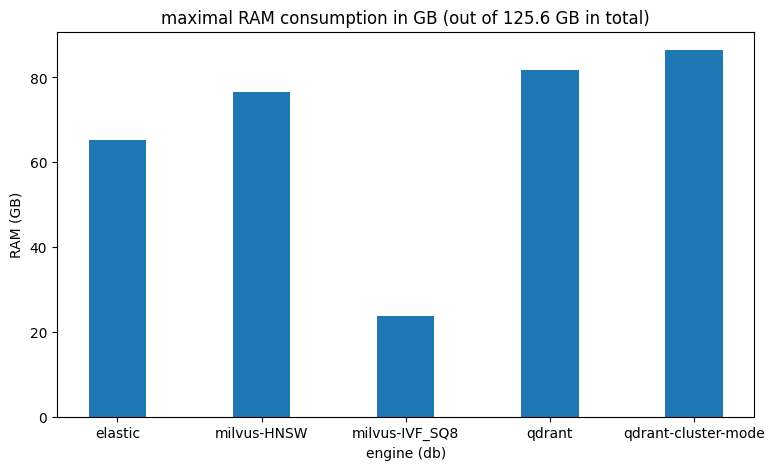

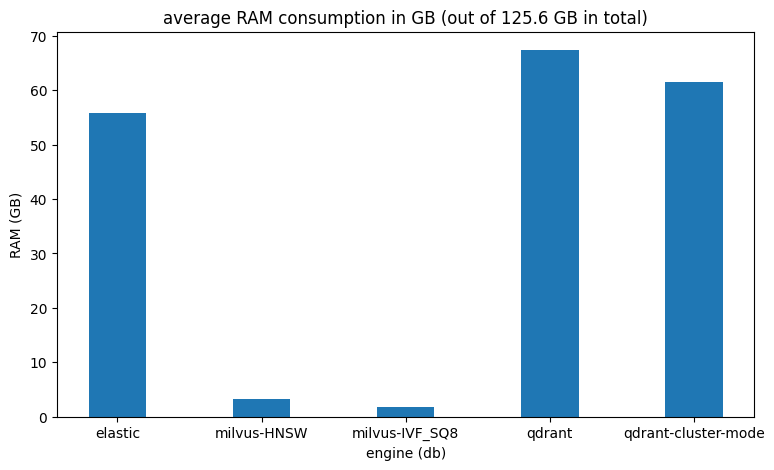

In [147]:
json_results = []

for index, row in joined_df.reset_index().iterrows():
    engine_params = {}
    
    if isinstance(row['params_upload'], dict):
        engine_params.update(row['params_upload'])
    if isinstance(row['params_search'], dict):
        search_params = row['params_search']
        engine_params.update(search_params.get('config', {}))
        engine_params.update(search_params.get('params', {}))
        engine_params.update(search_params.get('search_params', {}))
        engine_params.update(search_params.get('vectorIndexConfig', {}))

    engine_params.pop('experiment')
    engine_params.pop('parallel')

    engine_name = row['engine']

    if engine_name.startswith("qdrant-"):
        engine_name = "qdrant"

    json_object = {
        "engine_name": engine_name,
        "setup_name": f"{row['params_search']['experiment']}",
        "dataset_name": row['dataset'],
        "search_idx": row['search_index'],
        "upload_time": row['results_upload']['upload_time'],
        "total_upload_time": row['results_upload']['total_time'],
        "p95_time": row['results_search']['p95_time'],
        "rps": row['results_search']['rps'],
        "parallel": row['params_search']['parallel'],
        "p99_time": row['results_search']['p99_time'],
        "mean_time": row['results_search']['mean_time'],
        "mean_precisions": row['results_search']['mean_precisions'],
        "engine_params": engine_params,
    }
    json_results.append(json_object)

format = '%Y-%M-%dT%H-%M-%S'
now = datetime.now().replace(tzinfo=timezone.utc).strftime(format)

Path(f"results.json").write_text(json.dumps(json_results, indent=2))
Path(f"results-{now}.json").write_text(json.dumps(json_results, indent=2))

print(json_results[-1], len(json_results))

results_df = pd.DataFrame(json_results).sort_values("p99_time", ascending=True)
# results_df.to_csv('results.csv')
results_df

# plotting the results
results_df=results_df.sort_values("mean_precisions", ascending=True)

x_elastic_precision_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_elastic_rps_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['rps']
x_milvus_precision_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_milvus_rps_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['rps']
x_milvus_IVF_precision_thread_1=[1.0, 1.0, 1.0]
y_milvus_IVF_rps_thread_1=[19.85, 20.01, 20.06]
x_qdrant_precision_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_qdrant_rps_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['rps']
x_qdrant_cluster_mode_precision_thread_1=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==1)]['mean_precisions']
y_qdrant_cluster_mode_rps_thread_1=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==1)]['rps']

plt.figure(0)
plt.xlabel('precision')
plt.ylabel('rps')
plt.title('rps vs precision 1 thread search')
plt.plot(x_elastic_precision_thread_1,y_elastic_rps_thread_1,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_rps_thread_1,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_rps_thread_1,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_rps_thread_1,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_1,y_qdrant_cluster_mode_rps_thread_1,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()
x_qdrant_cluster_mode_precision_thread_1
y_qdrant_cluster_mode_rps_thread_1

x_elastic_precision_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_elastic_rps_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['rps']
x_milvus_precision_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_milvus_rps_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['rps']
x_milvus_IVF_precision_thread_100=[1.0, 1.0, 1.0]
y_milvus_IVF_rps_thread_100=[11.14, 10.75, 11.39]
x_qdrant_precision_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_qdrant_rps_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['rps']
x_qdrant_cluster_mode_precision_thread_100=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==100)]['mean_precisions']
y_qdrant_cluster_mode_rps_thread_100=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==100)]['rps']

plt.figure(1)
plt.xlabel('precision')
plt.ylabel('rps')
plt.title('rps vs precision 100 threads search')
plt.plot(x_elastic_precision_thread_100,y_elastic_rps_thread_100,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_100,y_milvus_rps_thread_100,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_100,y_milvus_IVF_rps_thread_100,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_100,y_qdrant_rps_thread_100,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_100,y_qdrant_cluster_mode_rps_thread_100,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()

y_elastic_latency_mean_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_elastic_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_elastic_latency_mean_thread_1]
y_milvus_latency_mean_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_milvus_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_milvus_latency_mean_thread_1]
y_milvus_IVF_latency_mean_thread_1_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_mean_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_qdrant_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_qdrant_latency_mean_thread_1]
y_qdrant_cluster_mode_latency_mean_thread_1=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==1)]['mean_time']
y_qdrant_cluster_mode_latency_mean_thread_1_millisec = [i * 1000.0 for i in y_qdrant_cluster_mode_latency_mean_thread_1]

plt.figure(2)
plt.xlabel('precision')
plt.ylabel('mean_latency (ms)')
plt.title('mean_latency (ms) vs precision 1 thread search')
plt.plot(x_elastic_precision_thread_1,y_elastic_latency_mean_thread_1_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_latency_mean_thread_1_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_latency_mean_thread_1_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_latency_mean_thread_1_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_1,y_qdrant_cluster_mode_latency_mean_thread_1_millisec,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()

y_elastic_latency_mean_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_elastic_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_elastic_latency_mean_thread_100]
y_milvus_latency_mean_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_milvus_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_milvus_latency_mean_thread_100]
y_milvus_IVF_latency_mean_thread_100_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_mean_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_qdrant_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_qdrant_latency_mean_thread_100]
y_qdrant_cluster_mode_latency_mean_thread_100=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==100)]['mean_time']
y_qdrant_cluster_mode_latency_mean_thread_100_millisec = [i * 1000.0 for i in y_qdrant_cluster_mode_latency_mean_thread_100]

plt.figure(3)
plt.xlabel('precision')
plt.ylabel('mean_latency (ms)')
plt.title('mean_latency (ms) vs precision 100 threads search')
plt.plot(x_elastic_precision_thread_100,y_elastic_latency_mean_thread_100_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_100,y_milvus_latency_mean_thread_100_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_100,y_milvus_IVF_latency_mean_thread_100_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_100,y_qdrant_latency_mean_thread_100_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_100,y_qdrant_cluster_mode_latency_mean_thread_100_millisec,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()

y_elastic_latency_p95_thread_1=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_elastic_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_elastic_latency_p95_thread_1]
y_milvus_latency_p95_thread_1=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_milvus_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_milvus_latency_p95_thread_1]
y_milvus_IVF_latency_p95_thread_1_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_p95_thread_1=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_qdrant_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_qdrant_latency_p95_thread_1]
y_qdrant_cluster_mode_latency_p95_thread_1=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==1)]['p95_time']
y_qdrant_cluster_mode_latency_p95_thread_1_millisec = [i * 1000.0 for i in y_qdrant_cluster_mode_latency_p95_thread_1]
plt.figure(4)
plt.xlabel('precision')
plt.ylabel('p95_latency (ms)')
plt.title('p95_latency (ms) vs precision 1 thread search')
plt.plot(x_elastic_precision_thread_1,y_elastic_latency_p95_thread_1_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_latency_p95_thread_1_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_latency_p95_thread_1_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_latency_p95_thread_1_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_1,y_qdrant_cluster_mode_latency_p95_thread_1_millisec,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()

y_elastic_latency_p95_thread_100=results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_elastic_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_elastic_latency_p95_thread_100]
y_milvus_latency_p95_thread_100=results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_milvus_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_milvus_latency_p95_thread_100]
y_milvus_IVF_latency_p95_thread_100_millisec=[50.19, 49.80, 49.70]
y_qdrant_latency_p95_thread_100=results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_qdrant_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_qdrant_latency_p95_thread_100]
y_qdrant_cluster_mode_latency_p95_thread_100=results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==100)]['p95_time']
y_qdrant_cluster_mode_latency_p95_thread_100_millisec = [i * 1000.0 for i in y_qdrant_cluster_mode_latency_p95_thread_100]
plt.figure(5)
plt.xlabel('precision')
plt.ylabel('p95_latency (ms)')
plt.title('p95_latency (ms) vs precision 100 threads search')
plt.plot(x_elastic_precision_thread_100,y_elastic_latency_p95_thread_100_millisec,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_100,y_milvus_latency_p95_thread_100_millisec,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_100,y_milvus_IVF_latency_p95_thread_100_millisec,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_100,y_qdrant_latency_p95_thread_100_millisec,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_100,y_qdrant_cluster_mode_latency_p95_thread_100_millisec,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()

y_elastic_upload_time_thread_1=list(results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_elastic_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_elastic_index_time_thread_1=[y_elastic_total_upload_time_thread_1[i] - y_elastic_upload_time_thread_1[i] for i in range(len(y_elastic_upload_time_thread_1))]
y_milvus_upload_time_thread_1=list(results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_milvus_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='milvus-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_milvus_index_time_thread_1=[y_milvus_total_upload_time_thread_1[i] - y_milvus_upload_time_thread_1[i] for i in range(len(y_milvus_upload_time_thread_1))]
y_milvus_IVF_index_time_thread_1=[20029.12, 20029.12, 20029.12]
y_qdrant_upload_time_thread_1=list(results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_qdrant_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='qdrant-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_qdrant_index_time_thread_1=[y_qdrant_total_upload_time_thread_1[i] - y_qdrant_upload_time_thread_1[i] for i in range(len(y_qdrant_upload_time_thread_1))]
y_qdrant_cluster_mode_upload_time_thread_1=list(results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==1)]['upload_time'])
y_qdrant_cluster_mode_total_upload_time_thread_1=list(results_df[(results_df['setup_name']=='qdrantcluster-m-16-ef-128') & (results_df['parallel']==1)]['total_upload_time'])
y_qdrant_cluster_mode_index_time_thread_1=[y_qdrant_cluster_mode_total_upload_time_thread_1[i] - y_qdrant_cluster_mode_upload_time_thread_1[i] for i in range(len(y_qdrant_cluster_mode_upload_time_thread_1))]
plt.figure(6)
plt.xlabel('precision')
plt.ylabel('index_time (s)')
plt.title('index_time (s) vs precision')
plt.plot(x_elastic_precision_thread_1,y_elastic_index_time_thread_1,marker='*',c='b', label='elasticsearch-m-16-ef-128')
plt.plot(x_milvus_precision_thread_1,y_milvus_index_time_thread_1,marker='*',c='r', label='milvus-m-16-ef-128')
plt.plot(x_milvus_IVF_precision_thread_1,y_milvus_IVF_index_time_thread_1,marker='*',c='g', label='milvus-IVF_SQ8')
plt.plot(x_qdrant_precision_thread_1,y_qdrant_index_time_thread_1,marker='*',c='y', label='qdrant-m-16-ef-128')
plt.plot(x_qdrant_cluster_mode_precision_thread_1,y_qdrant_cluster_mode_index_time_thread_1,marker='*',c='m', label='qdrant-cluster-mode')
plt.legend()

#memory consumption plots
#method to convert string percentage to float, e.g. "20.3%" -> 0.203
def p2f(x):
    return float(x.strip('%'))/100
max_RAM=125.6

memory_consumption_milvus=dict()
memory_consumption_milvus_list=[]
memory_consumption_milvus_ivfsq8=dict()
memory_consumption_milvus_ivfsq8_list=[]
memory_consumption_elastic=dict()
memory_consumption_elastic_list=[]
memory_consumption_qdrant=dict()
memory_consumption_qdrant_list=[]
memory_consumption_qdrant_cluster=dict()
memory_consumption_qdrant_cluster_node1_list=[]
memory_consumption_qdrant_cluster_node2_list=[]
memory_consumption_qdrant_cluster_node3_list=[]
with open('milvus-memory-consumption.json') as json_file:
    memory_consumption_milvus = json.load(json_file)
    for elem in memory_consumption_milvus:
        if(elem['Name']=="milvus-standalone-benchmark"):
            memory_consumption_milvus_list.append(p2f(elem['MemPerc'])*max_RAM)
with open('milvusIVFSQ8-memory-consumption.json') as json_file:
    memory_consumption_milvus_ivfsq8 = json.load(json_file)
    for elem in memory_consumption_milvus_ivfsq8:
        if(elem['Name']=="milvus-standalone-benchmark"):
            memory_consumption_milvus_ivfsq8_list.append(p2f(elem['MemPerc'])*max_RAM)
with open('elasticsearch-memory-consumption.json') as json_file:
    memory_consumption_elastic = json.load(json_file)
    for elem in memory_consumption_elastic:
        memory_consumption_elastic_list.append(p2f(elem['MemPerc'])*max_RAM)
with open('qdrant-memory-consumption.json') as json_file:
    memory_consumption_qdrant = json.load(json_file)
    for elem in memory_consumption_qdrant:
        memory_consumption_qdrant_list.append(p2f(elem['MemPerc'])*max_RAM)
with open('qdrantcluster-memory-consumption.json') as json_file:
    memory_consumption_qdrant_cluster = json.load(json_file)
    for elem in memory_consumption_qdrant_cluster:
        if(elem['Name']=="qdrant-cluster-mode-qdrant-node-0-1"):
            memory_consumption_qdrant_cluster_node1_list.append(p2f(elem['MemPerc'])*max_RAM)
        if(elem['Name']=="qdrant-cluster-mode-qdrant-node-1-1"):
            memory_consumption_qdrant_cluster_node2_list.append(p2f(elem['MemPerc'])*max_RAM)
        if(elem['Name']=="qdrant-cluster-mode-qdrant-node-2-1"):
            memory_consumption_qdrant_cluster_node3_list.append(p2f(elem['MemPerc'])*max_RAM)

x_memory_consumption=["elastic", "milvus-HNSW", "milvus-IVF_SQ8", "qdrant", "qdrant-cluster-mode"]
plt.figure(figsize = (9, 5))
plt.xlabel('engine (db)')
plt.ylabel('RAM (GB)')
plt.title('minimal RAM consumption in GB (out of 125.6 GB in total)')
y_memory_consumption_minimal=[]
y_memory_consumption_minimal.append(min(memory_consumption_elastic_list))
y_memory_consumption_minimal.append(min(memory_consumption_milvus_list))
y_memory_consumption_minimal.append(min(memory_consumption_milvus_ivfsq8_list))
y_memory_consumption_minimal.append(min(memory_consumption_qdrant_list))
y_memory_consumption_minimal.append(min(memory_consumption_qdrant_cluster_node1_list) + min(memory_consumption_qdrant_cluster_node2_list) + min(memory_consumption_qdrant_cluster_node3_list))
plt.bar(x_memory_consumption, y_memory_consumption_minimal, width = 0.4)

plt.figure(figsize = (9, 5))
plt.xlabel('engine (db)')
plt.ylabel('RAM (GB)')
plt.title('maximal RAM consumption in GB (out of 125.6 GB in total)')
y_memory_consumption_maximal=[]
y_memory_consumption_maximal.append(max(memory_consumption_elastic_list))
y_memory_consumption_maximal.append(max(memory_consumption_milvus_list))
y_memory_consumption_maximal.append(max(memory_consumption_milvus_ivfsq8_list))
y_memory_consumption_maximal.append(max(memory_consumption_qdrant_list))
y_memory_consumption_maximal.append(max(memory_consumption_qdrant_cluster_node1_list) + max(memory_consumption_qdrant_cluster_node2_list) + max(memory_consumption_qdrant_cluster_node3_list))
plt.bar(x_memory_consumption, y_memory_consumption_maximal, width = 0.4)

plt.figure(figsize = (9, 5))
plt.xlabel('engine (db)')
plt.ylabel('RAM (GB)')
plt.title('average RAM consumption in GB (out of 125.6 GB in total)')
y_memory_consumption_avg=[]
y_memory_consumption_avg.append(sum(memory_consumption_elastic_list)/len(memory_consumption_elastic_list))
y_memory_consumption_avg.append(sum(memory_consumption_milvus_list)/len(memory_consumption_milvus_list))
y_memory_consumption_avg.append(sum(memory_consumption_milvus_ivfsq8_list)/len(memory_consumption_milvus_ivfsq8_list))
y_memory_consumption_avg.append(sum(memory_consumption_qdrant_list)/len(memory_consumption_qdrant_list))
y_memory_consumption_avg.append(sum(memory_consumption_qdrant_cluster_node1_list)/len(memory_consumption_qdrant_cluster_node1_list) + sum(memory_consumption_qdrant_cluster_node2_list)/len(memory_consumption_qdrant_cluster_node2_list) + sum(memory_consumption_qdrant_cluster_node3_list)/len(memory_consumption_qdrant_cluster_node3_list))
plt.bar(x_memory_consumption, y_memory_consumption_avg, width = 0.4)

#results_df[(results_df['setup_name']=='elasticsearch-m-16-ef-128') & (results_df['parallel']==100)].plot.scatter(x = 'mean_precisions', y = 'rps', c = 'red'); 